# Chapter 1: Introduction

This notebook explores a simple temporal-difference (TD) learning algorithm on the game tic-tac-toe (and some variations).

In [1]:
from collections import defaultdict
from typing import *
from enum import Enum
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

import seaborn as sns
sns.set()

from envs import tictactoe
import utilities

ttt = tictactoe.TicTacToeEnv()

def seed(s):
    random.seed(s)
    np.random.seed(s)

(1, 1)


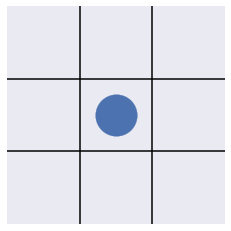

In [2]:
class AgentSession(object):
    def act(self, state):
        raise NotImplemented
        
    def reward(self, state, reward):
        pass

class Agent(object):
    def reset(self):
        pass
    
    def bind(self, player):
        return AgentSession()
    
class RandomAgent(Agent, AgentSession):
    def __init__(self, name):
        self.name = name
    
    def bind(self, player):
        return self
                    
    def act(self, state):
        return state.random_action
                                
rando = RandomAgent("Rando")
state = ttt.reset()
action = rando.act(state)
print(action)
ttt.step(action)
ttt.render(mode='matplotlib')


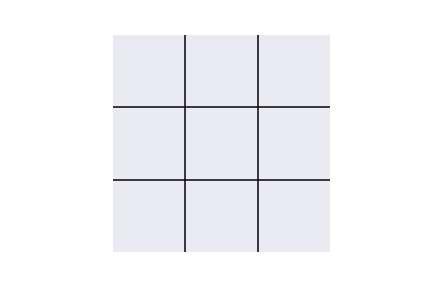

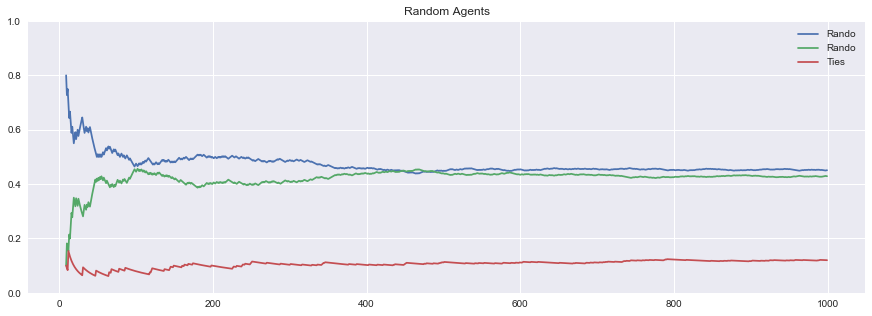

In [3]:
class PlayerAssignment(NamedTuple):
    player: int
    agent_index: int
    agent_session: AgentSession

class Matchup(object):
    def __init__(self, env, *agents):
        if env.n_players != len(agents):
            raise ValueError('Please specify one agent for each player.')
        self.env = env
        self.agents = list(agents)
        
    def run(self, reward=True):
        # Randomly assign an agent to a player position.
        players = list(range(1, self.env.n_players+1))
        random.shuffle(players)
        player_assignments = {}
        for agent_index, player in enumerate(players):
            agent_session = self.agents[agent_index].bind(player)
            player_assignments[player] = PlayerAssignment(player, agent_index, agent_session)
                    
        state = self.env.reset()
        game = [state]
        done = False
        while not done:
            agent_session = player_assignments[state.next_player].agent_session
            action = agent_session.act(state)
            state, reward, done, info = self.env.step(action)
            game.append(state)
        
        last_agent = player_assignments[state.last_player].agent_index
        game_result = GameResult(self, last_agent, game, reward)
        if reward:
            for player, reward in game_result.rewards:
                player_assignments[player].agent_session.reward(state, reward)
            
        return game_result
    
    def run_many(self, games, reward=True):
        results = [self.run(reward=reward) for game in range(games)]
        return GameSeries(self, results)

class GameResult(NamedTuple):
    matchup: Matchup
    last_agent: int
    game: List[tictactoe.BoardState]
    reward: tictactoe.Reward
        
    @property
    def end_state(self):
        return self.game[-1]
    
    @property
    def last_player(self):
        return self.end_state.last_player
        
    @property
    def rewards(self):
        rewarded_player = self.last_player
        for player in self.end_state.player_order:
            reward = self.reward if player == rewarded_player else -self.reward
            yield player, reward
    
    def animate(self):
        plotter = tictactoe.BoardStatePlotter()
        fig = plt.figure()
        frames = [plotter.plot(state) for state in self.game]
        ani = animation.ArtistAnimation(fig, frames, blit=True)
        utilities.display_animation(ani, fps=2)
            
class GameSeries(object):
    def __init__(self, matchup, results):
        self.matchup = matchup
        self.results = results
        
    def plot(self, title=None):
        '''Plots win-rate over a series of games.'''        
        shape = (len(self.results), len(self.matchup.agents))
        wins = np.zeros(shape=shape)
        for i, result in enumerate(self.results):
            wins[i, result.last_agent] = result.reward
        
        ties = np.array([1 if result.reward == 0 else 0 for result in self.results]).reshape(-1, 1)
        data = np.concatenate([wins, ties], axis=1)
        
        columns = [agent.name for agent in self.matchup.agents] + ['Ties']
        win_rate = pd.DataFrame(data, columns=columns).rolling(1000, min_periods=10).mean()
        win_rate.plot(figsize=(15, 5), ylim=(0,1))
        if title is not None:
            plt.title(title)
                                    
rando_vs_rando = Matchup(ttt, rando, rando)
rando_vs_rando.run().animate()
rando_vs_rando.run_many(1000).plot('Random Agents')

## Exercise 1

For the first exercise, I have implemented a temporal difference (TD) agent to learn to play the game of tic-tac-toe. It does have some prior knowledge of the game in that it knows the rules of the game: valid moves and what state will follow a given action.

As a first test, it uses a simple linear update method with $\alpha = 0.1$, and an epsilon-greedy exploration policy with $\epsilon = 0.1$.

It learns slowly, but eventually converges on a win-rate approaching 90% against a random opponent.


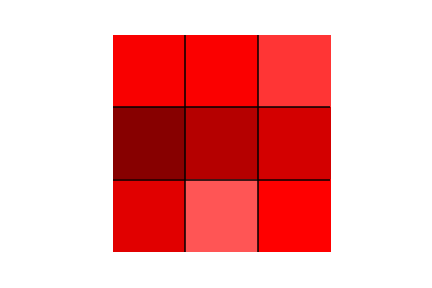

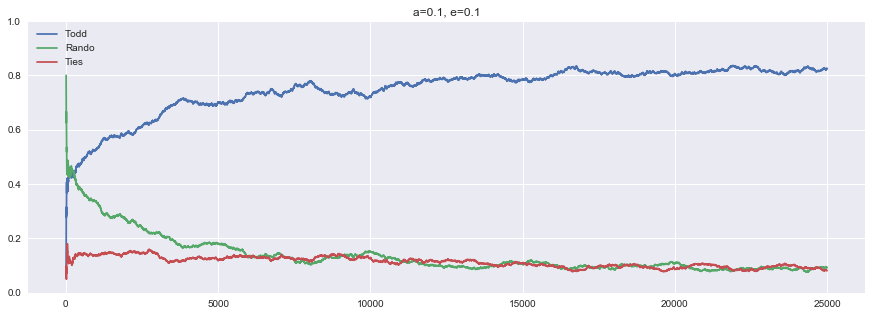

In [4]:
class LinearUpdate(object):
    def __init__(self, alpha=0.1, decay=1.):
        self.alpha = alpha
        self.decay = decay
        
    def __call__(self, v0, v1):
        new_val = v0 + self.alpha * (v1 - v0)
        self.alpha *= self.decay
        return new_val
        
class EpsilonGreedy(object):
    def __init__(self, epsilon=0.1, learn_from_explore=False, decay=1.):
        self.epsilon = epsilon
        self.learn_from_explore = learn_from_explore
        self.decay = decay
        
    def __call__(self, action_scores):
        explore = np.random.random() < self.epsilon
        self.epsilon *= self.decay
        actions = list(action_scores.keys())

        if explore:
            random.shuffle(actions)
            return self.learn_from_explore, actions[0]
        else:
            actions = sorted(actions, key=lambda action: action_scores[action])
            return True, actions[-1] # Sorted ascending

class TDAgentSession(object):
    def __init__(self, agent, player):
        self.agent = agent
        self.values = agent.values[player]
        self.prev_state = None
        
    def learn(self, state, learn, action):
        next_state = state(action)
        if learn:
            self.back_propagate(self.prev_state, next_state)
        self.prev_state = next_state
        
    def act(self, state):
        acting_player = state.next_player
        valid_actions = list(state.valid_actions)
        action_scores = {action: self.values[state(action)] for action in valid_actions}
        
        learn, action = self.agent.choose_action(action_scores)
        self.learn(state, learn, action)
        return action
    
    def back_propagate(self, state0, state1):
        '''Update the value of state0 with the value of state1.'''
        val0 = self.values[state0]
        val1 = self.values[state1]
        new_val = self.agent.update_value(val0, val1)
        self.values[state0] = new_val

    def reward(self, end_state, reward):
        self.values[end_state] = float(reward)
        self.back_propagate(self.prev_state, end_state)
        
class TDAgent(object):
    def __init__(self, choose_action, update_value, name='TD'):
        '''A simple temporal-difference learning agent.
        This particular agent has a prior knowledge of the game being played (TTT), in that
        it knows which moves are valid.
        '''
        self.choose_action = choose_action
        self.update_value = update_value
        self.name = name
        self.reset()
        
    def reset(self):
        # Dictionary of player -> state -> value
        # Initialize with a small amount of randomness so a pure-greedy algorithm won't be
        # entirely deterministic.
        self.values = defaultdict(lambda: defaultdict(lambda: np.random.normal(0, 0.1)))
        
    def bind(self, player):
        return TDAgentSession(self, player)
            
    def plot(self, state, ax=None):
        if ax is None:
            ax = plt.gca()
        
        values = np.zeros((3,3))
        for action in state.valid_actions:
            next_state = state(action)
            player = state.next_player
            
            values[action[0], action[1]] = self.values[player][next_state]
        ims = ax.imshow(values, interpolation='nearest', cmap='seismic', vmin=-1, vmax=1)
        return ims

    def animate(self, game_result, player=1):
        fig = plt.figure()
        ax = plt.gca()
        plotter = tictactoe.BoardStatePlotter()
        
        def render_frame(state):
            board = plotter.plot(state, ax)
            values = self.plot(state, ax)
            return board + [values]
        
        frames = [render_frame(state) for state in game_result.game]
        ani = animation.ArtistAnimation(fig, frames, blit=True)
        utilities.display_animation(ani, fps=1)
        
todd = TDAgent(EpsilonGreedy(0.1), LinearUpdate(0.1), 'Todd')
todd_vs_rando = Matchup(ttt, todd, rando)

series = todd_vs_rando.run_many(25000)
series.plot('a=0.1, e=0.1')

last_game = series.results[-1]
todd.animate(last_game)

## Exercise 1.1: Self-Play

> Suppose, instead of playing against a random opponent, the reinforcement learning algorithm described above played against itself, with both sides learning. What do you think would happen in this case? Would it learn a different policy for selecting moves?

The agent, playing against itself, quickly learns to force a tie in the majority of games.  It learns a different policy than playing against a random opponent: playing on the edges more often than the diagonol spaces (which are more efficient if you are trying to win).

An interesting observation is that the plot of tie-rate over time appears to fluctuate (while trending upwards). The agent occasionally stumbles upon a move that allows it to break the stalemate in the favor of one player or another for a time, but after a while, it learns how to defeat the new strategy (by forcing a tie).


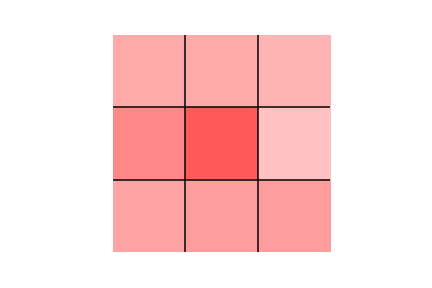

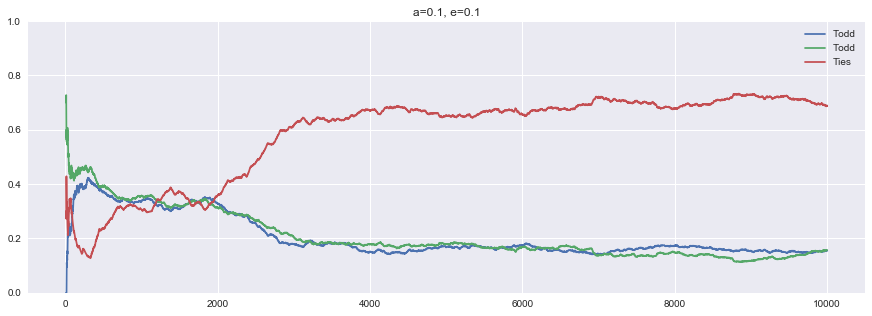

In [5]:
seed(42)
todd.reset()
series = Matchup(ttt, todd, todd).run_many(10000)
series.plot('a=0.1, e=0.1')
todd.animate(series.results[-1])

## Exercise 1.2: Symmetries

> Many tic-tac-toe positions appear different but are really the same because of symmetries. How might we amend the learning process described above to take advantage of this? In what ways would this change improve the learning process?

We could amend the state-value function to treat symmetric states as having an equal value.  This would improve the learning rate, because the state-space would be greatly decreased.

> Now think again. Suppose the opponent did not take advantage of symmetries. In that case, should we? Is it true, then, that symmetrically equivalent positions should necessarily have the same value?

While taking advantage of symmetries would increase the learning rate, it could be non-optimal against a non-optimal opponent.  For example, suppose an opponent that more often makes mistakes on one side of the board. By treating all symmetric states as equal, a learning agent would not be able to take advantage of these biased mistakes.

## Exercise 1.3: Greedy Play

> Suppose the reinforcement learning player was greedy, that is, it always played the move that brought it to the position that it rated the best. Might it learn to play better, or worse, than a nongreedy player? What problems might occur?

A greedy agent is at the mercy of the random number generator.  If it stumbles upon a good policy by random chance, it will initially do very well - exploiting that policy repeatedly, until the opponent eventually learns how to defeat it. However, if it stumbles upon a poor policy (especially a local maxima), it will learn very slowly.

As an aside, this behavior reminds me of a type of player in StarCraft and other online, competive games: they learn a single strategy that works (perhaps by finding a strategy online) and then play it repeatedly, even in the face of evidence that the strategy fails to work.  As they don't explore other strategies, they do not learn quickly.

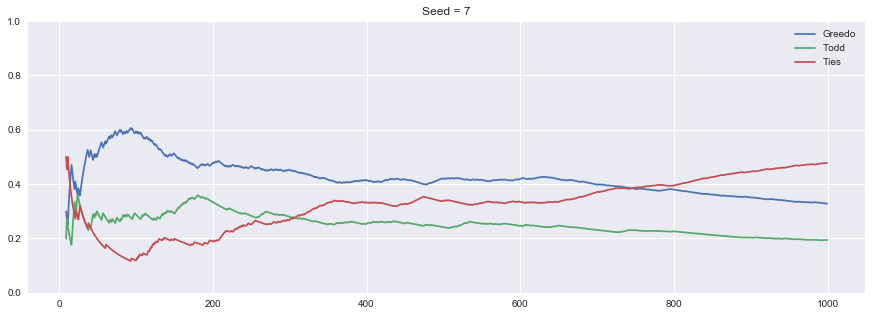

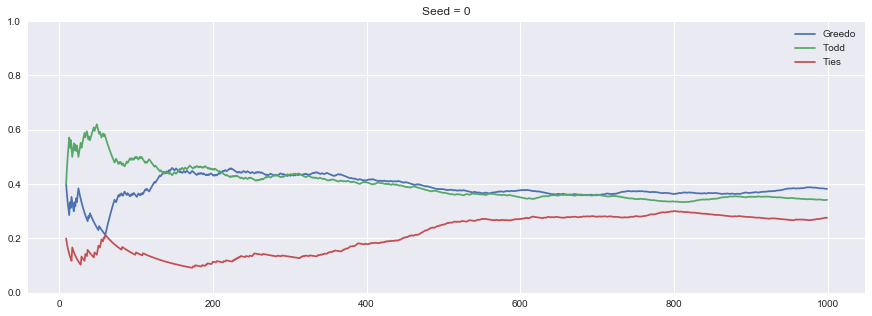

In [6]:
greedo = TDAgent(EpsilonGreedy(0.), LinearUpdate(0.1), 'Greedo')

def g_vs_t(s):
    seed(s)
    greedo.reset()
    todd.reset()
    Matchup(ttt, greedo, todd).run_many(1000).plot('Seed = {}'.format(s))

g_vs_t(7)
g_vs_t(0)

## Exercise 1.4: Learning from Exploration

> Suppose learning updates occurred after all moves, including exploratory moves. If the step-size parameter is appropriately reduced over time (but not the tendency to explore), then the state values would converge to a set of probabilities. What are the two sets of probabilities computed when we do, and when we do not, learn from exploratory moves?

> Assuming that we do continue to make exploratory moves, which set of probabilities might be better to learn?
Which would result in more wins?


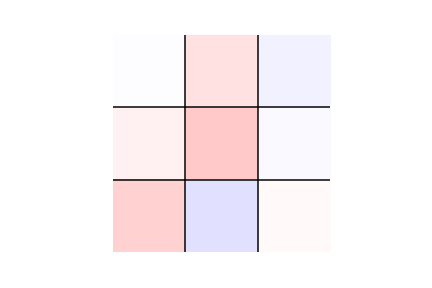

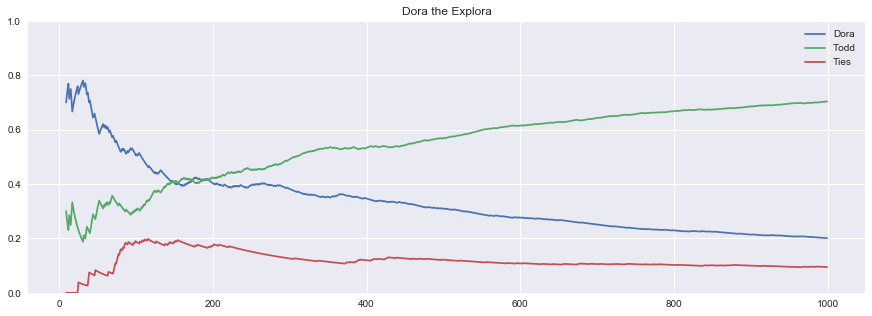

In [7]:
dora = TDAgent(EpsilonGreedy(0.1, learn_from_explore=True), LinearUpdate(0.1, decay=0.9), 'Dora')
todd.reset()
series = Matchup(ttt, dora, todd).run_many(1000)
series.plot('Dora the Explora')
dora.animate(series.results[-1])

# Exercise 1.5: Other Improvements

> Can you think of other ways to improve the reinforcement learning player?

1. Instead of updating the values of states during play, it would be more efficient to back propogate the end-of-game reward through all the states of a game.  That way, learning happens immediately, instead of whenever a state is encountered a second time.
2. Instead of a flat chance to explore, some other methods of exploration may work better, such as:
  * using a softmax function to choose an action,
  * taking variance into account when exploring,
  * or decreasing epsilon over time.

> Can you think of any better way to solve the tic-tac-toe problem as posed?

Since tic-tac-toe is an easily solvable game, a min-max approach would do well against an optimally-playing opponent.  If we want to also be able to take advantage of mistakes that an opponent makes, it may also be a good idea to learn to predict what the opponent will do, and use that information in our decision.

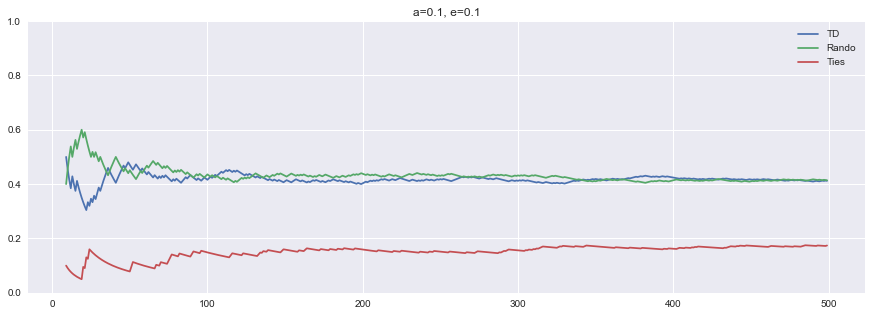

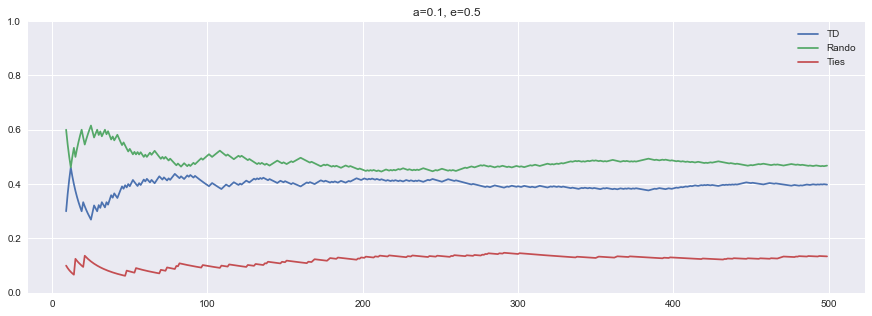

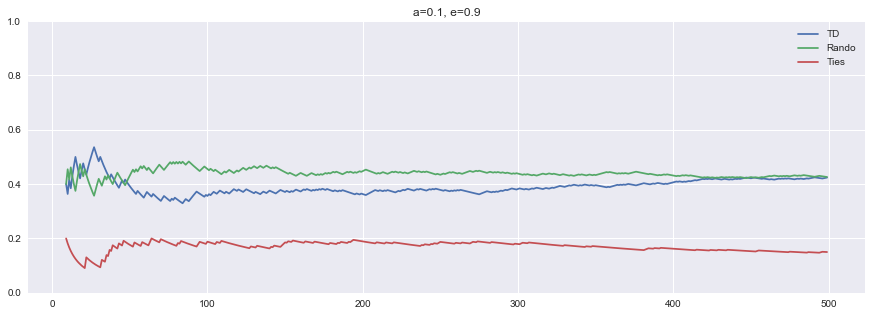

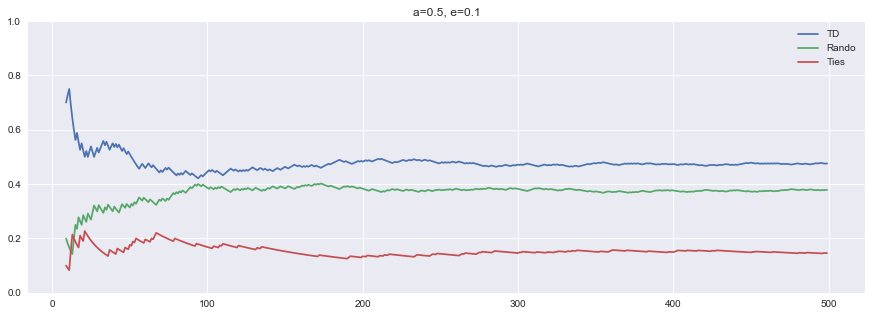

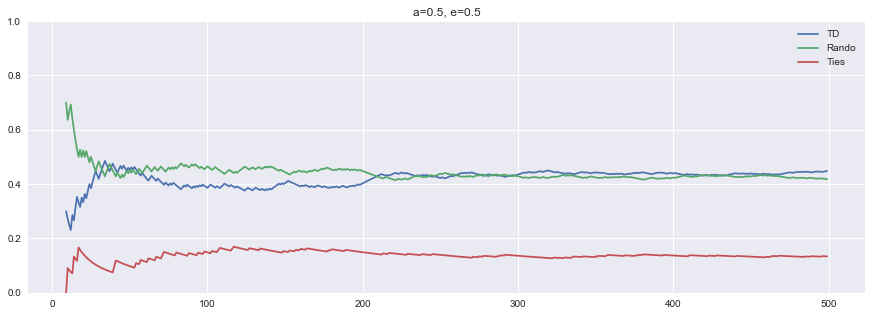

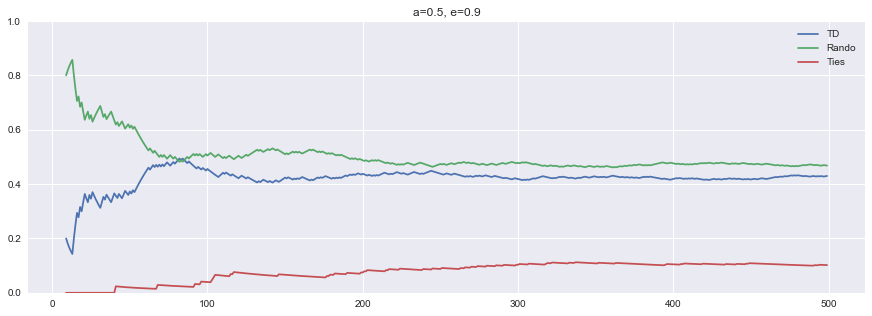

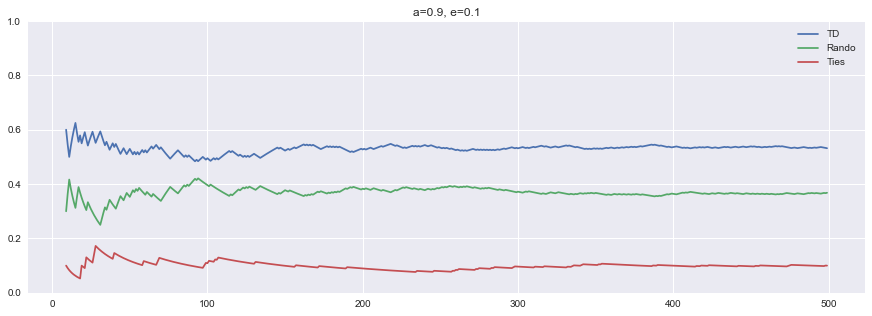

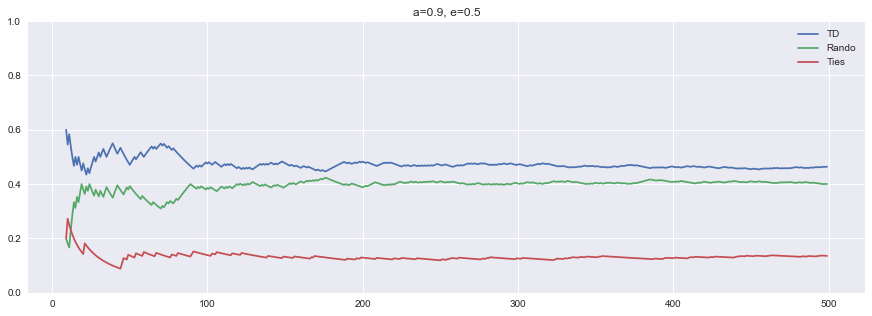

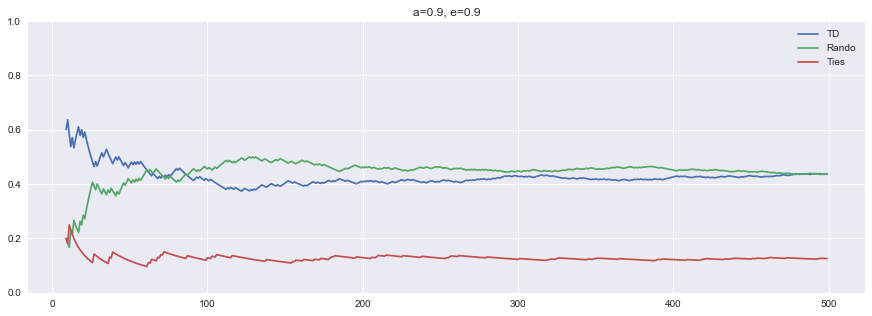

In [8]:
for alpha in [0.1, 0.5, 0.9]:
    for epsilon in [0.1, 0.5, 0.9]:
        td = TDAgent(EpsilonGreedy(epsilon), LinearUpdate(alpha))
        title = 'a={}, e={}'.format(alpha, epsilon)
        Matchup(ttt, td, rando).run_many(500).plot(title)

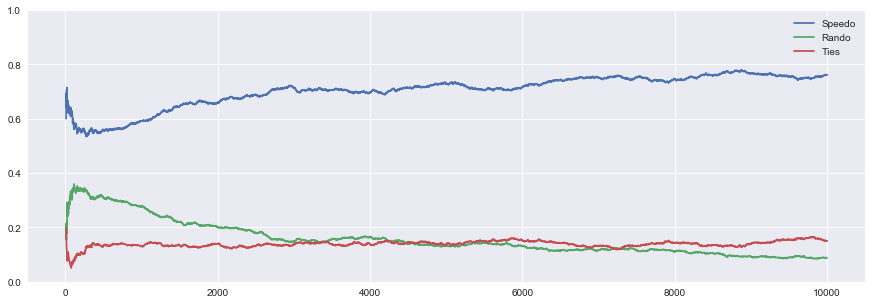

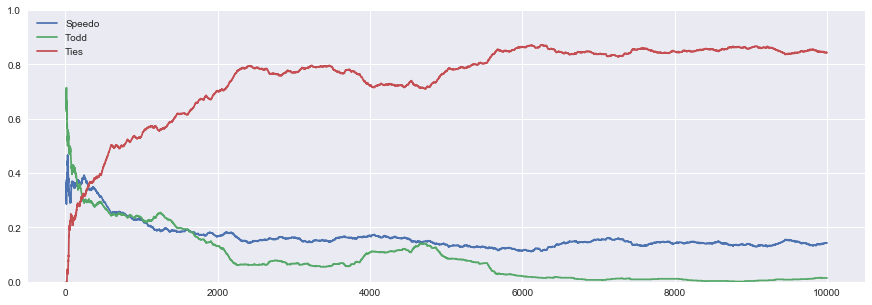

In [9]:
class TDFastAgentSession(TDAgentSession):
    def __init__(self, agent, player):
        super().__init__(agent, player)
        self.states = []
    
    def learn(self, state, learn, action):
        next_state = state(action)
        self.states.append(next_state)
    
    def reward(self, end_state, reward):
        self.values[end_state] = float(reward)
        next_state = end_state
        for prev_state in reversed(self.states):
            self.back_propagate(prev_state, next_state)
            next_state = prev_state
            
class TDFastAgent(TDAgent):        
    def bind(self, player):
        return TDFastAgentSession(self, player)
    
speedo = TDFastAgent(EpsilonGreedy(1., decay=0.99), LinearUpdate(), 'Speedo')
todd.reset()
Matchup(ttt, speedo, rando).run_many(10000).plot()
Matchup(ttt, speedo, todd).run_many(10000).plot()


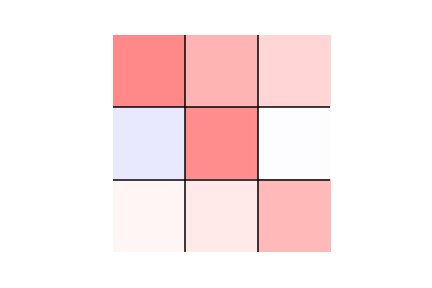

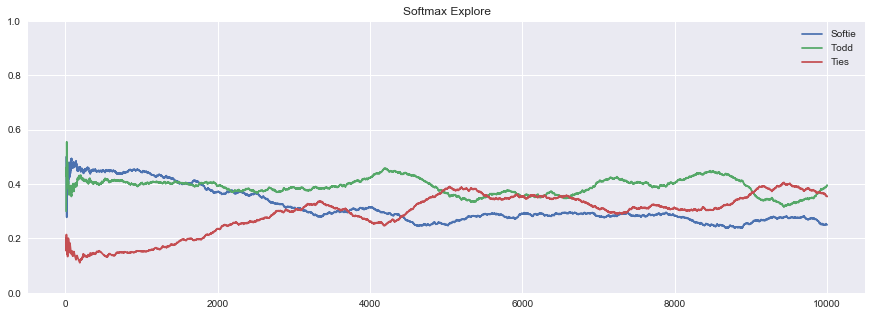

In [10]:
def softmax(arr):
    ps = np.exp(arr)
    ps /= np.sum(ps)
    return ps

class SoftMaxChoose(object):
    def __init__(self, theta=1.0):
        self.theta = theta
        
    def __call__(self, action_scores):
        actions = list(action_scores.keys())
        scores = np.array(list(action_scores.values()))
        probs = softmax(scores * self.theta)
        idx = np.random.choice(len(scores), p=probs)
        return True, actions[idx]
    
softie = TDFastAgent(SoftMaxChoose(5.0), LinearUpdate(), 'Softie')
todd.reset()
series = Matchup(ttt, softie, todd).run_many(10000)
series.plot('Softmax Explore')
softie.animate(series.results[-1])